### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

### Notebook Structure

1. **Generation of the Model: MobileNet for Weather Classification**
2. **Compiling the Model for AURIX&trade; Microcontrollers**

# MobileNet for Weather Classification

In this an example for the classification of different weather conditions using the MobileNetV3-small [1]. The pretrained model will be the foundation applying transfer learning. The model will be tested and then transformed into code which can later be deployed on the AURIX&trade; microcontroller family. 

### Generation of the Model

In this section we will import the MobileNetV3-small. Next, we will replace the classification layer with a new one for two classes. We will train the model for weather classification and then validate the results.

In [1]:
import os
import sys

from torchsummary import summary
import modelling_helper as mh

import torch.nn as nn
import torch.optim as optim

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.python_flask_client import CallTools
import CentralScripts.helper_functions as cs

Fetching data aka setting dataloader. The data which is used is Raindrop Clarify [2]. While this was designed for removing rain drops from images algorithmically, it will here be used for classification only. The data will be downloaded and restructured. From the original dataset only, clear and (rain) drop will be considered. The data will be split into train, validation (val), and test piles. Plotting a random input.

Data available in data/DayRainDrop_Train!


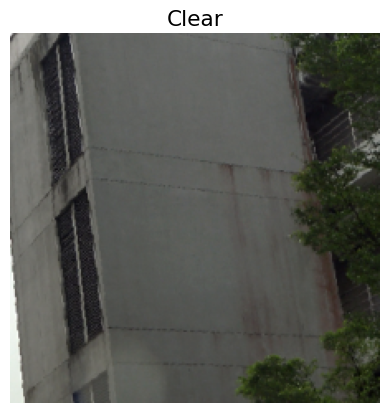

In [2]:
batch_size = 16
path = mh.fetch_sort_data()
dataloader, class_names, dataset_sizes = mh.get_dataloader(
    os.path.join(path, "train"), batch_size, mode="train"
)
_, input_size = mh.get_input_dataloader(dataloader, is_plot=True)

Loading the MobileNetV3-small with pretrained weights. It's trained on ImageNet1K dataset [3]. Replacing the classification layer with one for two classes only (rain and clear weather).

In [3]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

model_original = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model = mh.adapt_model(model_original, number_classes=2)
summary(model, input_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

Applying transfer learning: training the new classification layer only.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[-1].parameters(), lr=0.01, momentum=0.9)
mh.train_model(model, dataloader, dataset_sizes, criterion, optimizer)

Epoch 1/10
Loss: 0.1317, accuracy: 0.9480
Epoch 2/10
Loss: 0.0888, accuracy: 0.9663
Epoch 3/10
Loss: 0.1078, accuracy: 0.9606
Epoch 4/10
Loss: 0.1089, accuracy: 0.9621
Epoch 5/10
Loss: 0.1147, accuracy: 0.9609
Epoch 6/10
Loss: 0.1047, accuracy: 0.9626
Epoch 7/10
Loss: 0.1090, accuracy: 0.9631
Epoch 8/10
Loss: 0.1089, accuracy: 0.9653
Epoch 9/10
Loss: 0.1077, accuracy: 0.9626
Epoch 10/10
Loss: 0.1174, accuracy: 0.9593
Maximim accuracy: 0.9663


Getting a random input which can be used for testing on the hardware later.

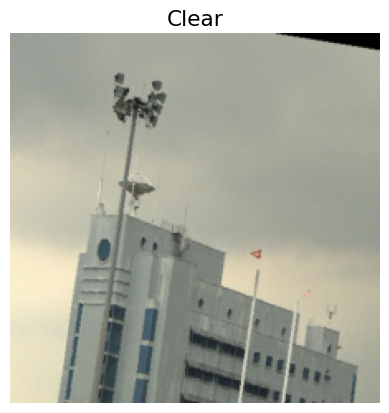

In [5]:
input_target, _ = mh.get_input_dataloader(dataloader, is_plot=True)
output_target = cs.get_predictions("torch", model, input_target)

Testing the trained model on a few samples.

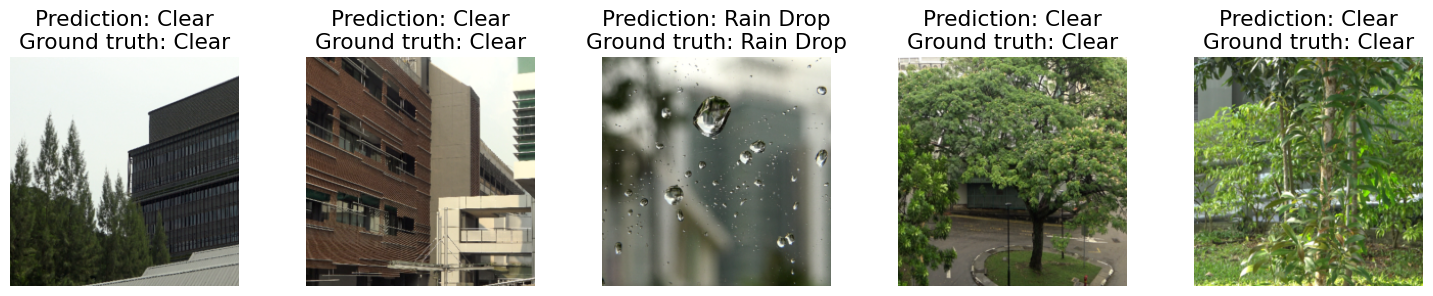

In [6]:
classes = mh.get_rain_classes()
mh.calculate_predictions_and_plot(model, os.path.join(path, "test"), classes)

Testing the trained model on the test data set.

Loss: 0.0243, accuracy: 0.9905


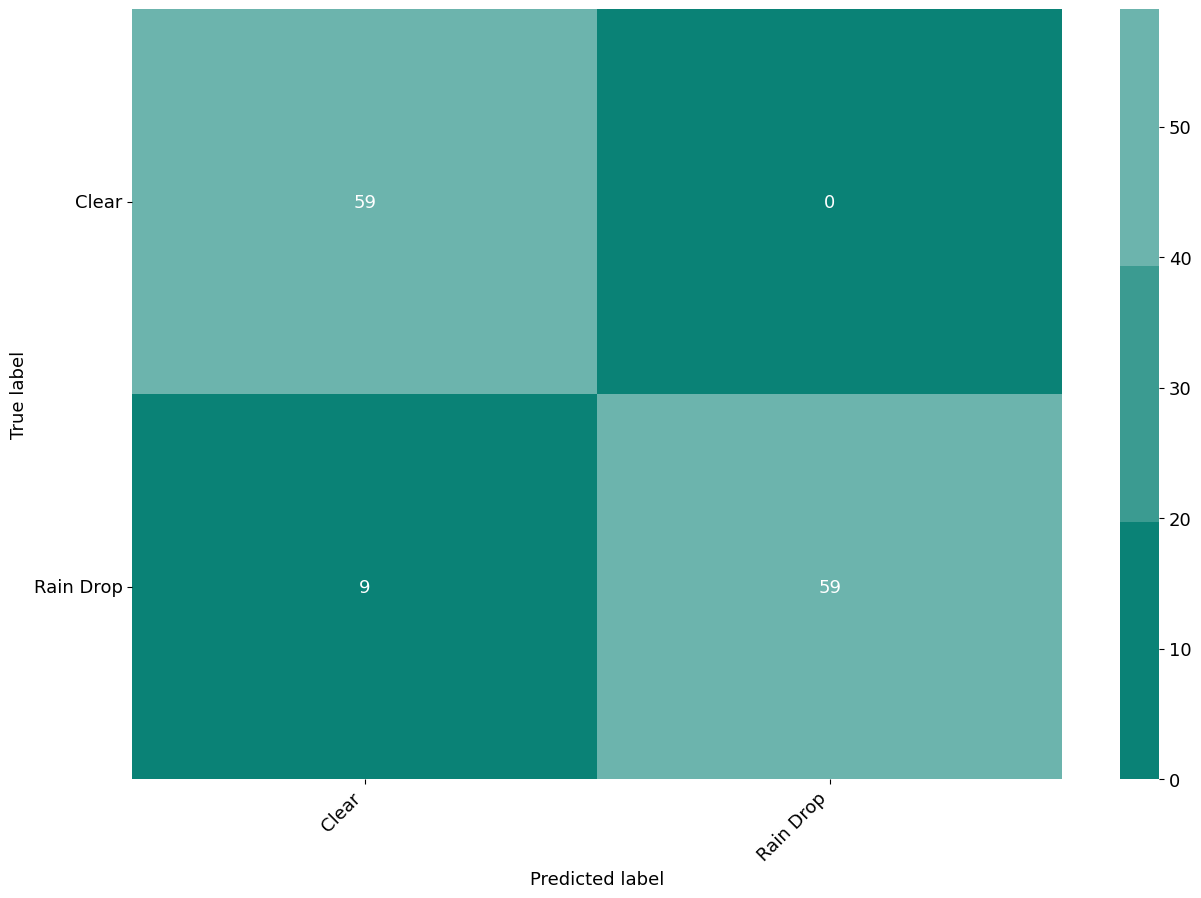

In [7]:
dataloader, class_names, dataset_sizes = mh.get_dataloader(
    os.path.join(path, "test"), batch_size, mode="test"
)
mh.test_model(model, dataloader, dataset_sizes, criterion)

Saving the model and some input and output data.

In [8]:
model_name = "mobilenet_weather"
cs.save_all(model_name, input_target, output_target, model, origin="torch")

Directory already exists: out/mobilenet_weather/test_mobilenet_weather
Model loaded from out/mobilenet_weather/test_mobilenet_weather/model.onnx


## Compiling the Model for AURIX&trade; Microcontrollers

For compiling, we prepare a Docker container which includes all the required tools for compilation. In this section, we will set up the container and make sure that it's available. 

In [9]:
cs.ensure_docker_container()

Docker container 'unruffled_galois' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


Compiling the model for two different targets: AURIX&trade; TC3x and TC4x.

In [10]:
model_folder, onnx_model_file = cs.get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/mobilenet_weather/test_mobilenet_weather/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/mobilenet_weather/test_mobilenet_weather/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


Comparing the run time of the layers using AURIX&trade; TC3x and TC4x.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


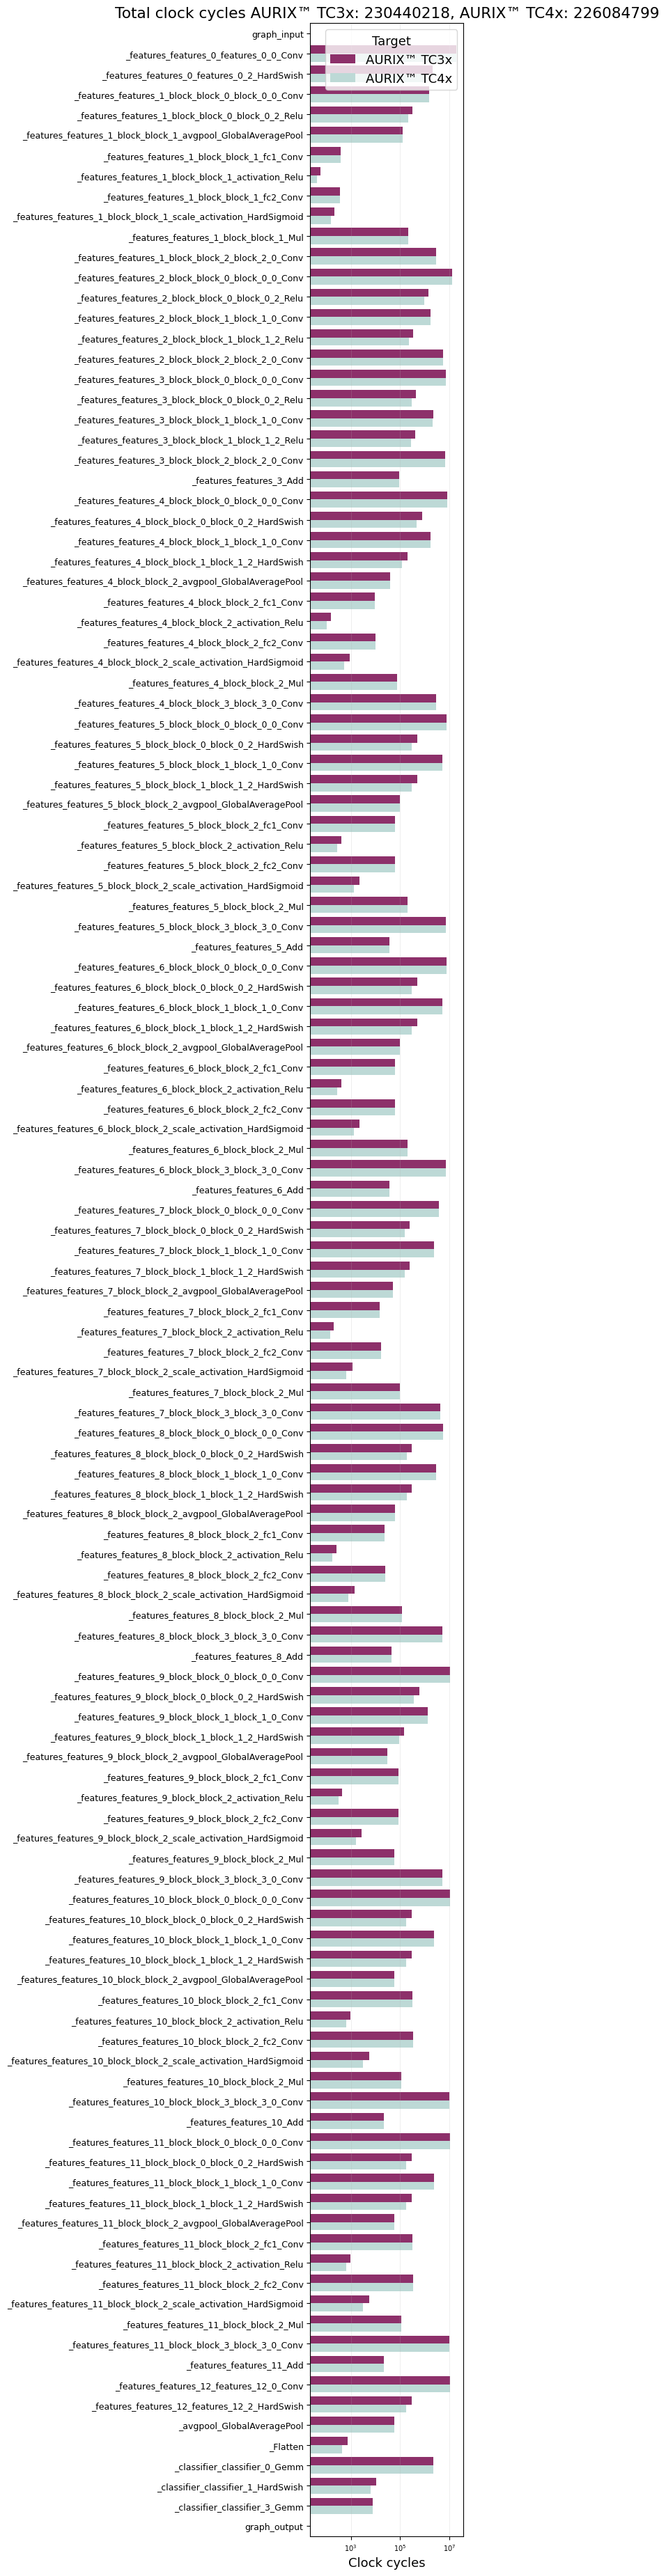

In [11]:
cs.plot_execution_timing(model_name, is_small_font=True)

[1]: Howard, A. et al. (2019). "Searching for MobileNetV3.", ICCV.<br>
[2]: Jin, Y. et al. (2024). "Raindrop Clarity: A Dual-Focused Dataset for Day and Night Raindrop Removal", ECCV, [Link to Github](https://github.com/jinyeying/RaindropClarity?tab=readme-ov-file)<br>
[3]: Russakovsky, O. et al. (2015). "ImageNet Large Scale Visual Recognition Challenge", IJCV